In [49]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
#maybe not useful:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import seaborn as sns

In [2]:
from sklearn.svm import SVC

In [3]:
from sklearn.model_selection import GridSearchCV

In [5]:
"""
x_train = pd.read_csv("../data/x_train.csv", encoding = "ISO-8859-1")
y_train = pd.read_csv("../data/y_train.csv", encoding = "ISO-8859-1")

x_val = pd.read_csv("../data/x_val.csv", encoding = "ISO-8859-1")
y_val = pd.read_csv("../data/y_val.csv", encoding = "ISO-8859-1")"""

'\nx_train = pd.read_csv("../data/x_train.csv", encoding = "ISO-8859-1")\ny_train = pd.read_csv("../data/y_train.csv", encoding = "ISO-8859-1")\n\nx_val = pd.read_csv("../data/x_val.csv", encoding = "ISO-8859-1")\ny_val = pd.read_csv("../data/y_val.csv", encoding = "ISO-8859-1")'

In [6]:
df= pd.read_csv('../data/final.csv')

In [7]:
df[df.doc.isnull()]

,Unnamed: 0,level_0,index,text,directed_at,emotion,target,brand,doc,original_text


In [8]:
df.drop(index=6, axis=0, inplace=True)

In [9]:
df.shape

(8935, 10)

In [10]:
target = df["target"]
features = df['doc']
features

0       .@wesley83 3 G iPhone 3 hrs tweet rise_austin ...
1       @jessedee know @fludapp Awesome iPad iPhone ap...
2                       @swonderlin wait iPad 2 sale SXSW
3       @sxsw hope year festival crashy year iPhone ap...
4       @sxtxstate great stuff Fri SXSW Marissa Mayer ...
                              ...                        
8931                                       Ipad SXSW link
8932    wave buzz rt @mention interrupt regularly sche...
8933    Google Zeiger physician report potential ae FD...
8934    Verizon iPhone customer complain time fall hou...
8935       RT @mention Google Tests check offer SXSW link
Name: doc, Length: 8935, dtype: object

In [11]:
target.shape

(8935,)

In [12]:
features.shape

(8935,)

### Train Test Split

In [13]:
x_full, x_test, y_full, y_test = train_test_split(features, target, test_size=.2)
x_train, x_val, y_train, y_val = train_test_split(x_full, y_full, test_size=.2)

## Feature Engineering


In [14]:
tf = TfidfVectorizer()

In [15]:
tf_train = tf.fit_transform(x_train)
tf_val = tf.transform(x_val)
train_df = pd.DataFrame(tf_train.todense(), columns=tf.get_feature_names())
val_df = pd.DataFrame(tf_val.todense(), columns=tf.get_feature_names())

### Resampling

In [30]:
y_train.value_counts()

0    3457
2    1904
1     357
Name: target, dtype: int64

In [31]:
neutral_train_index = y_train[y_train==0]
negative_train_index = y_train[y_train==1]
positive_train_index = y_train[y_train==2]

In [32]:
negative_train_index

169     1
822     1
4782    1
7918    1
993     1
       ..
67      1
1452    1
1337    1
4447    1
6846    1
Name: target, Length: 357, dtype: int64

In [33]:
neg_train.shape[0]

3457

In [34]:
neg_train = train_df.loc[negative_train_index]
neg_train["target"] = 0
pos_train = train_df.loc[positive_train_index]
pos_train["target"] = 1
neu_train = train_df.loc[neutral_train_index]
neu_train["target"] = 2

neg_upsample = resample(neg_train,
                        replace = True,
                        n_samples = neu_train.shape[0] - neg_train.shape[0]
                       )
pos_upsample = resample(neg_train,
                        replace = True,
                        n_samples = neu_train.shape[0] - pos_train.shape[0]
                       )

display(neg_train.shape)
display(pos_train.shape)
display(neg_upsample.shape)
display(pos_upsample.shape)
display(neu_train.shape)

resampled_train = pd.concat([neg_upsample, neg_train,
                             pos_upsample, pos_train,
                             neu_train],
                            ignore_index = True)

display(resampled_train.shape)

#x_train = resampled_train
resampled_y_train = resampled_train["target"]
#y_train = y_train["target"]
resampled_train.drop(["target"], axis = 1, inplace = True)

(357, 6604)

(1904, 6604)

(3100, 6604)

(1553, 6604)

(3457, 6604)

(10371, 6604)

### Naive Bayes

In [35]:
gnb = GaussianNB()

In [36]:
gnb.fit(train_df, y_train)
y_pred = gnb.predict(val_df)

In [37]:
accuracy_score(y_pred, y_val)

0.46853146853146854

In [50]:
confusion_matrix(y_val,y_pred)

array([[724,  15, 133],
       [ 45,  23,  22],
       [248,   4, 216]])

### Multinomial Bayes

In [40]:
mnb = MultinomialNB(alpha=0.4)
mnb.fit(train_df, y_train)
y_pred = mnb.predict(val_df)
f1_score(y_pred, y_val, average='macro')

0.4795712655663325

In [41]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')

In [42]:
params = [{'alpha':[x/20 for x in list(range(0, 20))]}]
gridsearch = GridSearchCV( MultinomialNB(), params, scoring=f1, cv=5, verbose=1, n_jobs=-1)

In [43]:
gridsearch.fit(train_df,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.9s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid=[{'alpha': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,
                                    0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75,
                                    0.8, 0.85, 0.9, 0.95]}],
             scoring=make_scorer(f1_score, average=macro), verbose=1)

In [44]:
gridsearch.best_params_

{'alpha': 0.05}

In [ ]:
#gridsearch.mo

In [46]:
mnb = MultinomialNB(gridsearch.best_params_['alpha'])
mnb.fit(train_df, y_train)
y_pred = mnb.predict(val_df)
f1_score(y_pred, y_val, average='macro')
accuracy_score(y_pred, y_val)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass alpha=0.05 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


0.6734265734265734

In [52]:
mnb_matrix = confusion_matrix(y_val,y_pred)

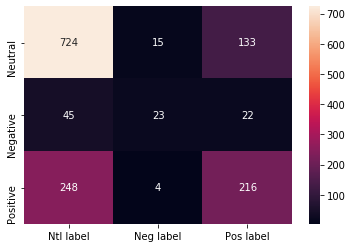

In [56]:
sns.heatmap(mnb_matrix,
            annot=True,
            xticklabels = ["Ntl label", "Neg label", "Pos label"],
            yticklabels = ["Neutral", "Negative", "Positive"],
            fmt='g'
           )

### Support Vector Classification

In [57]:
svc = SVC(C=10, class_weight='balanced', gamma='scale', kernel='rbf')
svc.fit(train_df,  y_train)

SVC(C=10, class_weight='balanced')

In [58]:
y_pred = svc.predict(val_df)
print(accuracy_score(y_pred, y_val))

0.6783216783216783


In [59]:
confusion_matrix(y_val,y_pred)

array([[700,  14, 158],
       [ 43,  21,  26],
       [216,   3, 249]])